In [3]:

from torch.nn import functional as FF
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import BatchSampler, DataLoader, Dataset, Sampler
from tqdm import tqdm
import yaml
import wandb
from dataloader_jetnet import PointCloudDataloader

ckpt="./ckpts/jet.ckpt"
config=yaml.load(open("./default_jet.yaml"),Loader=yaml.FullLoader)

In [4]:


from fit import MDMA
import pytorch_lightning as pl
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.weight_norm as weight_norm
from torch.nn import Parameter

from helpers import TPReLU, WeightNormalizedLinear
config["sampler"]=False
data_module = PointCloudDataloader(**config)
data_module.setup("fit")
config["L2"]=False
model =MDMA.load_from_checkpoint(ckpt,**config)
model.bins=[100,100,100]
model.n_dim = 3
model.scaler=data_module.scaler
model.w1m_best=0.01
model.min_pt=data_module.min_pt
model.max_pt=data_module.max_pt
mins=torch.ones(config["n_dim"]).unsqueeze(0)
maxs=torch.ones(config["n_dim"]).unsqueeze(0)
n=[]
for i in data_module.train_dataloader():
    mins=torch.min(torch.cat((mins,i[0][~i[1]].min(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    maxs=torch.max(torch.cat((maxs,i[0][~i[1]].max(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    n.append((~i[1]).sum(1))
model.maxs=maxs.cuda()
model.mins=mins.cuda()
model.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.gen_net.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.dis_net.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.swa=False
model.scaler.to(model.device)
model.scaled_mins=torch.tensor(data_module.mins).cuda()
model.scaled_maxs=torch.tensor(data_module.maxs).cuda()
# model.on_validation_epoch_start=on_validation_epoch_start
trainer = pl.Trainer(
        devices=1,
        accelerator="gpu",
    )
trainer.validate(model, dataloaders=data_module.test_dataloader())

/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_jetnet/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_jetnet/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unles

Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]sample lengths: 50000 50000
0.00047636275499942705


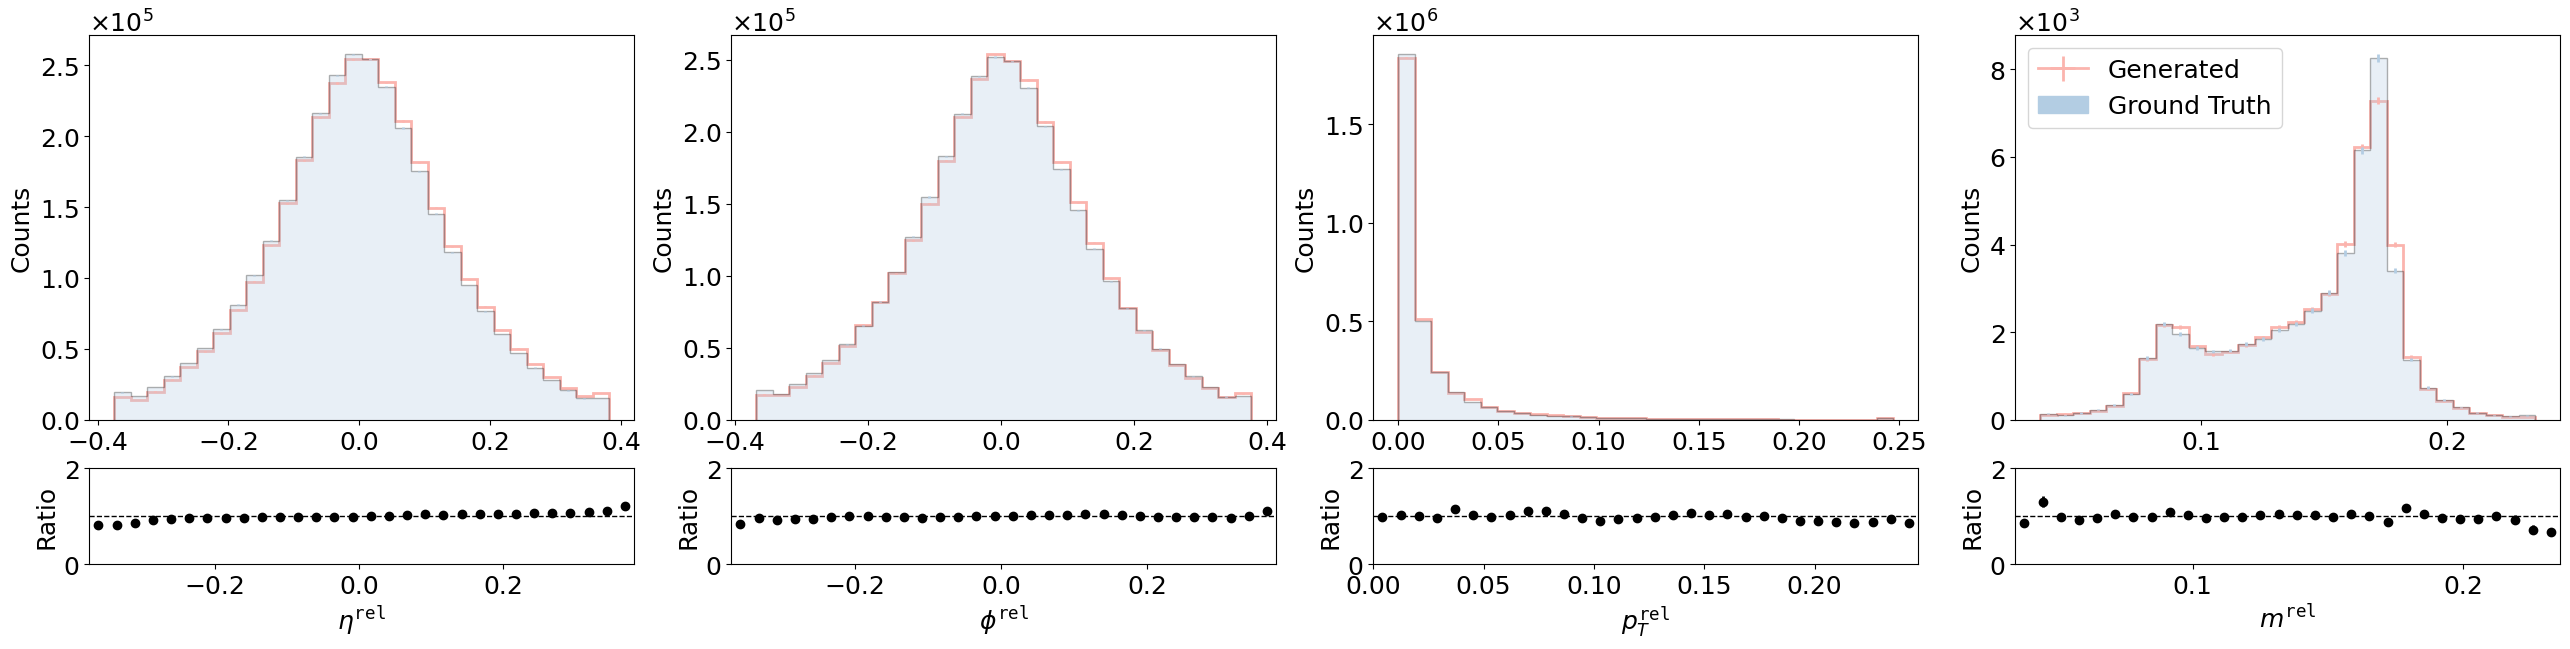

In [ ]:

class plotting_point_cloud():
    '''This is a class that takes care of  plotting steps in the script,
        It is initialized with the following arguments:
        true=the simulated data, note that it needs to be scaled
        gen= Generated data , needs to be scaled
        step=The current step of the training, this is need for tensorboard
        model=the model that is trained, a bit of an overkill as it is only used to access the losses
        config=the config used for training
        logger=The logger used for tensorboard logging'''
    def __init__(self,step=None,logger=None,weight=1):

        self.step=step
        self.weight=weight
        self.fig_size1=[6.4, 6.4]
        self.fig_size2=[2*6.4, 6.4]
        self.fig_size3=[3*6.4, 6.4]
        self.fig_size4=[4*6.4, 6.4]
        self.alpha=0.3
        mpl.rcParams['lines.linewidth'] = 2
        font = { "size": 18}#"family": "normal",
        mpl.rc("font", **font)
        mpl.rc('lines', linewidth=2)
        sns.set_palette("Pastel1")
        if logger is not None:
            self.summary=logger
        else:
            self.summary = None
    def plot_ratio(self,h_real,h_fake,weighted,leg=-1):
        i = 0
        k = 0
        fig, ax = plt.subplots(2, 4, gridspec_kw={"height_ratios": [4, 1]}, figsize=self.fig_size4)
        # plt.suptitle("All Particles", fontsize=18)
        for v, name in zip(["eta", "phi", "pt", "m"], [r"$\eta^{\tt rel}$", r"$\phi^{\tt rel}$", r"$p_T^{\tt rel}$", r"$m^{\tt rel}$"]):
            main_ax_artists, sublot_ax_arists = h_fake[k].plot_ratio(
            h_real[k],
            ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
            rp_ylabel=r"Ratio",
            bar_="blue",
            rp_num_label="Generated",
            rp_denom_label="Ground Truth",
            rp_uncert_draw_type="line",  # line or bar)
            )
            i += 1
            ax[0, k].set_xlabel("")
            ax[0, k].patches[1].set_fill(True)
            ax[0, k].ticklabel_format(axis="y", style="scientific", scilimits=(-3, 3), useMathText=True)
            ax[0, k].patches[1].set_fc(sns.color_palette()[1])
            ax[0, k].patches[1].set_edgecolor("black")
            ax[0, k].patches[1].set_alpha(self.alpha)
            ax[1, k].set_xlabel(name)
            ax[0, k].set_ylabel("Counts")
            ax[1, k].set_ylabel("Ratio")
            ax[0, k].patches[0].set_lw(2)
            ax[0, k].get_legend().remove()
            ax[1,k].set_ylim(0,2)
            k += 1
            
            
        ax[0, leg].legend(loc="best", fontsize=18)
        handles, labels = ax[0, leg].get_legend_handles_labels()
        ax[0, -1].locator_params(nbins=4, axis="x")
        ax[1, -1].locator_params(nbins=4, axis="x")
        handles[1] = mpatches.Patch(color=sns.color_palette()[1], label="The red data")
        ax[0, leg].legend(handles, labels)
        plt.tight_layout(pad=0.2)
        # if not save==None:
        plt.savefig("jetnet.pdf",format="pdf")
        plt.show()
        plt.close()
from helpers import get_hists,mass
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.patches as mpatches
fake=torch.cat(model.fake)
true=torch.cat(model.batch)
m_f,m_t=mass(fake),mass(true)
mins=torch.quantile(torch.cat((fake.reshape(-1,3),true.reshape(-1,3))),0.001,dim=0)
maxs=torch.quantile(torch.cat((fake.reshape(-1,3),true.reshape(-1,3))),0.999,dim=0)
fake=torch.clamp(fake,min=mins,max=maxs)
true=torch.clamp(true,min=mins,max=maxs)
mins=torch.cat((mins,torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0).unsqueeze(0)))
maxs=torch.cat((maxs,torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0).unsqueeze(0)))*1.01
m_f=torch.clamp(m_f,min=torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0),max=torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0))
m_t=torch.clamp(m_t,min=torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0),max=torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0))
hists=get_hists([30,30,30,30],mins,maxs,calo=model.name=="calo")
masks=torch.cat(model.masks) 
for var in range(3):
    hists["hists_real"][var].fill(true.reshape(-1,3)[(true.reshape(-1,3)!=0).all(1)][:,var].cpu().numpy())
    hists["hists_fake"][var].fill(fake.reshape(-1,3)[(fake.reshape(-1,3)!=0).all(1)][:,var].cpu().numpy())
hists["hists_real"][3].fill(m_t.cpu().numpy())
hists["hists_fake"][3].fill(m_f.cpu().numpy())

plot=plotting_point_cloud()
plot.plot_ratio(hists["hists_real"],hists["hists_fake"],weighted=False,leg=-1)

# CaloChallenge



In [2]:
import copy
import math
import traceback

import hist
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from hist import Hist
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler, PowerTransformer,
                                   StandardScaler)
from torch.nn import functional as FF
from torch.nn.utils import spectral_norm, weight_norm
from torch.nn.utils.rnn import pad_sequence
# from comet_ml import Experiment
from torch.nn.utils.weight_norm import WeightNorm
from torch.optim.swa_utils import SWALR, AveragedModel
from torch.utils.data import BatchSampler, DataLoader, Dataset, Sampler
from tqdm import tqdm
import yaml
import wandb
from helpers import (MultiheadL2Attention, WeightNormalizedLinear,
                     plotting_point_cloud)
#from preprocess import ScalerBase,DQ,LogitTransformer
from preprocess_new import *
from preprocess_new import (DQ, DQLinear, LogitTransformer, ScalerBaseNew,
                            SqrtTransformer)
from fit import MDMA
from models import Disc, Gen
from helpers import get_hists
import losses


#from fit import MDMA
#from models import Gen,Disc
from dataloader_calo import PointCloudDataloader
def setup_model(config,data_module=None,model=False):
    if not model:
        model = MDMA(**config)
    if config["dataset"]=="calo":
        model.bins=[600,config["num_z"],config["num_alpha"],config["num_R"]]
        model.num_z, model.num_alpha, model.num_R = config["num_z"], config["num_alpha"], config["num_R"]
        model.E_loss=config["E_loss"]
        model.lambda_gp=config["lambda_gp"]
        model.lambda_response=config["lambda_response"]
        model.min_weighted_w1p=0.1
        model.min_w1p=0.1
        model.minE=0.01
        model.scaler = data_module.scaler
        model.n_dim = 4
        model.power_lambda = model.scaler.transfs[0].lambdas_[0]
        model.mean = model.scaler.transfs[0]._scaler.mean_[0]
        model.scale = model.scaler.transfs[0]._scaler.scale_[0]
        model.pos_mean = torch.tensor(model.scaler.transfs[1].steps[2][1].mean_).cuda()
        model.pos_scale = torch.tensor(model.scaler.transfs[1].steps[2][1].scale_).cuda()
        model.pos_max_scale = torch.tensor(model.scaler.transfs[1].steps[0][1].scale_).cuda()
        model.pos_min = torch.tensor(model.scaler.transfs[1].steps[0][1].min_).cuda()

    model.i=0
    model.loss = losses.hinge if config["gan"] == "hinge" else losses.wasserstein if config["gan"] == "wgan" else losses.least_squares
    model.gp = config["gp"]
    model.d_loss_mean=None
    model.g_loss_mean=None

    model.scaled_mins=torch.zeros(4).cuda()
    model.scaled_maxs=torch.tensor([1e9]+model.bins[1:]).cuda()
    model.swa=False
    return model

NAME="calo"
run="v0mdo0hz"
ckpt="./ckpts/calo.ckpt"
config=yaml.load(open("default_{}.yaml".format(NAME)),Loader=yaml.FullLoader)
model=MDMA.load_from_checkpoint(ckpt,**config)
torch.set_float32_matmul_precision('medium' )
data_module = PointCloudDataloader(**config)
data_module.setup("train")
state_dict=torch.load(ckpt,map_location="cpu")
config.update(**state_dict["hyper_parameters"])
model=setup_model(config,data_module,model)
model.swa=config["start_swa"]
model.load_datamodule(data_module)

#loop once through dataloader to find mins and maxs to clamp during training
mins=torch.ones(config["n_dim"]).unsqueeze(0)
maxs=torch.ones(config["n_dim"]).unsqueeze(0)
n=[]
for i in data_module.train_dataloader():
    mins=torch.min(torch.cat((mins,i[0][~i[1]].min(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    maxs=torch.max(torch.cat((maxs,i[0][~i[1]].max(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    n.append((~i[1]).sum(1))
model.maxs=maxs.cuda()
model.mins=mins.cuda()
model.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.gen_net.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.dis_net.avg_n=torch.cat(n,dim=0).float().cuda().mean()

scaler_calo.gz


/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch_wandb/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/dust/maxwell/user/kaechben/.conda/envs/torch_w ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch_wandb/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless th

Validation DataLoader 0: 100%|██████████| 1563/1563 [01:16<00:00, 20.42it/s]


Traceback (most recent call last):
  File "/home/kaechben/MDMACalo/fit.py", line 367, in calo_evaluation
    self.plot.plot_calo(self.hists_fake, self.hists_real, weighted=False)
  File "/home/kaechben/MDMACalo/helpers.py", line 295, in plot_calo
    self.summary.log_image("{}ratio".format("weighted " if weighted else "unweighted "), [fig],self.step)
AttributeError: 'CSVLogger' object has no attribute 'log_image'


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        features/R         │   0.0005942564064120242   │
│    features/R_weighted    │   0.0005942564064120242   │
│      features/alpha       │   3.974177567874285e-05   │
│  features/alpha_weighted  │   3.974177567874285e-05   │
│        features/z         │   0.0008412039987061473   │
│    features/z_weighted    │   0.0008412039987061473   │
│        features_E         │   5.127693417759316e-05   │
│          min_w1p          │   0.0003816197787436269   │
│     min_weighted_w1p      │   0.0004917340602656381   │
│            w1p            │   0.0003816197787436269   │
│       weighted_w1p        │   0.0004917340602656381   │
│        weighted_z         │   0.0008412039987061473   │
└───────────────────────────┴───────────────────────────┘

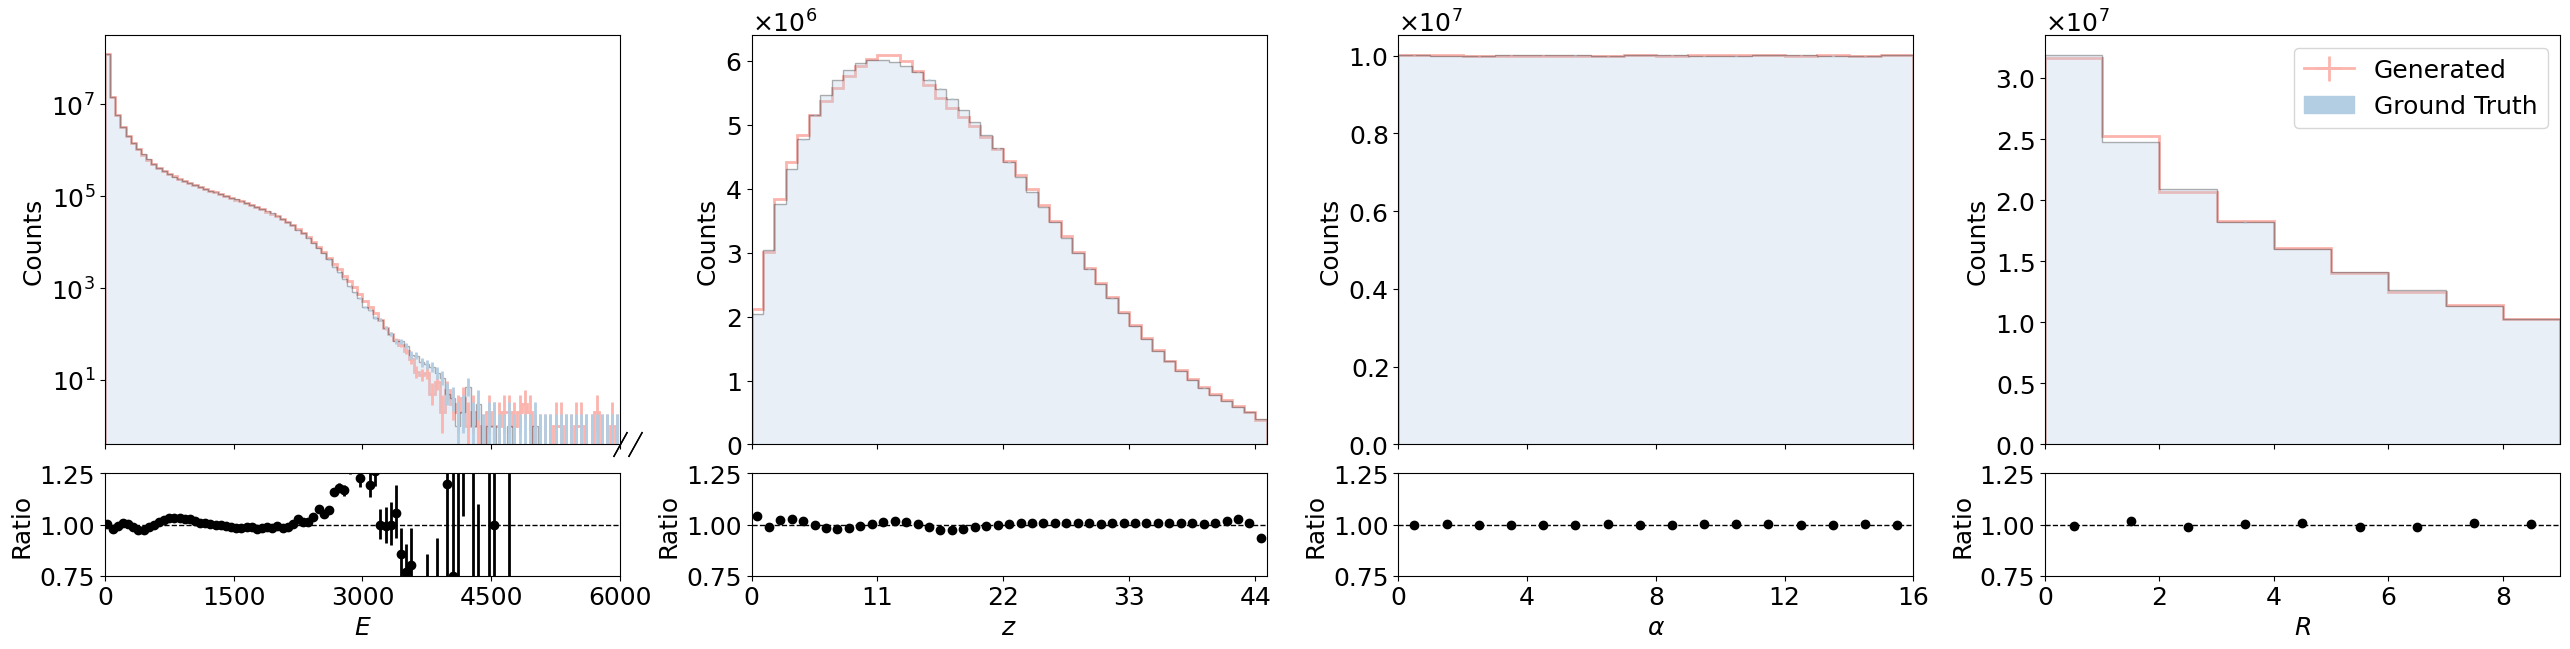

In [3]:

%matplotlib inline
torch.set_float32_matmul_precision('medium' )
from preprocess_new import LogitTransformer, ScalerBaseNew,DQLinear, Cart, SqrtTransformer
config["augmentation"]=False
trainer = pl.Trainer(devices=1,accelerator="gpu")
model.load_datamodule(data_module)
fakes=[]
conds=[]
masks=[]
batches=[]
trainer.validate(model,dataloaders=data_module.val_dataloader(),verbose=True)
batches.extend(model.batch)
fakes.extend(model.fake)
conds.extend(model.conds)
masks.extend(model.masks)

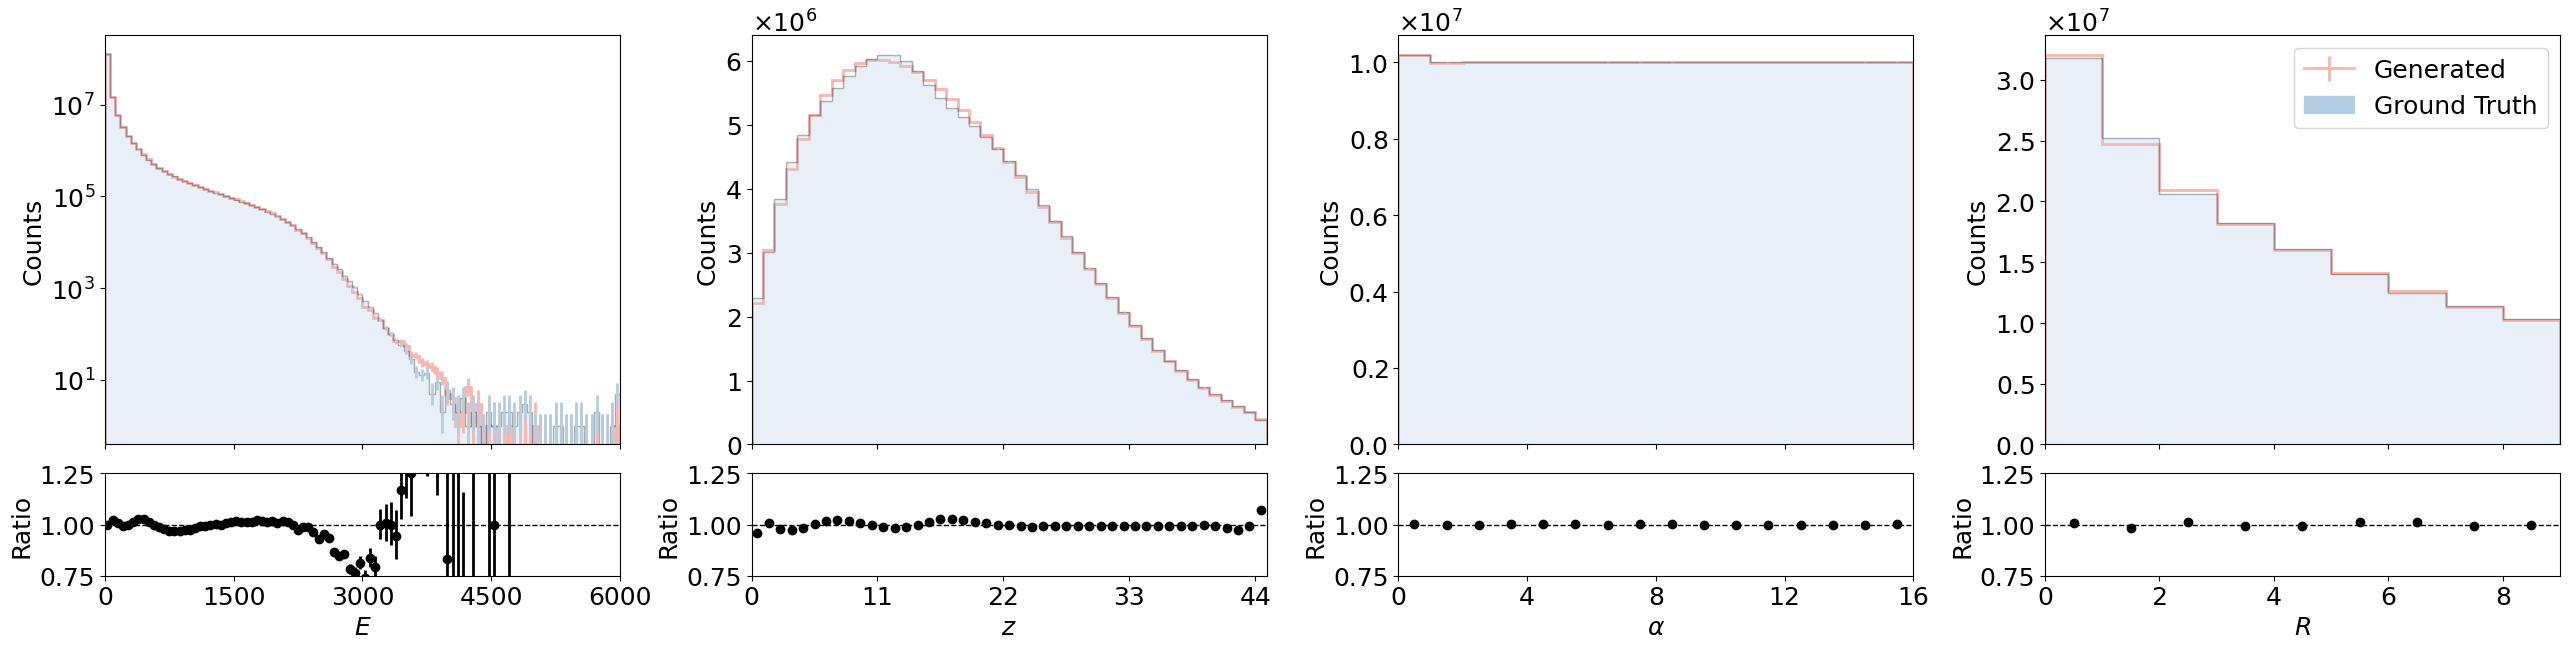

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
def plot_hists(h_real,h_fake,figsize,alpha):
        k=0
        fig,ax=plt.subplots(2,4 ,gridspec_kw={'height_ratios': [4, 1]},figsize=figsize,sharex="col")
       
        cols=["E","z","alpha","R"]
        names=[r"$E$",r"$z$",r"$\alpha$",r"$R$"]
        leg=-1
        for v,name in zip(cols,names):
            main_ax_artists, sublot_ax_arists = h_real[k].plot_ratio(
                h_fake[k],
                ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                rp_ylabel=r"Ratio",
                bar_="blue",
                rp_num_label="Generated",
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line",  # line or bar
            )
            ax[0,k].set_xlabel("")
            ax[0,k].patches[1].set_fill(True)
            ax[0,k].ticklabel_format(axis="y",style="scientific",scilimits=(-3,3),useMathText=True)
            ax[0,k].patches[1].set_fc(sns.color_palette()[1])
            ax[0,k].patches[1].set_edgecolor("black")
            ax[0,k].patches[1].set_alpha(alpha)
            ax[1,k].set_xlabel(name)
            ax[0,k].set_ylabel("Counts" )
            ax[1,k].set_ylabel("Ratio")
            if k==0:
                  ax[0,k].set_yscale("log")
            ax[0,k].patches[0].set_lw(2)
            ax[0,k].get_legend().remove()
            
            xticks=[int(h_real[k].axes[0].edges[-1]//4*i) for i in range(0,int(5))]

            ax[1,k].set_xticks(np.array(xticks),np.array(xticks))
            ax[0,k].set_xticks(np.array(xticks))
            

            ax[1,k].set_ylim(0.75,1.25)
            k+=1
      
        ax[0,leg].legend(loc="best",fontsize=18)
        handles, labels = ax[0,leg].get_legend_handles_labels()
        handles[1]=mpatches.Patch(color=sns.color_palette()[1], label='The red data')
        ax[0,leg].legend(handles, labels)
        plt.tight_layout(pad=0.2)
        plt.savefig("calo.pdf",format="pdf")
        plt.show()

        plt.close()
fake=torch.cat([x.reshape(-1,4) for x in model.fake])[:]
true=torch.cat([x.reshape(-1,4) for x in model.batch])[:]
# fake=torch.clamp(fake,model.scaled_mins.cpu(),model.scaled_maxs.cpu()-1)
# true=torch.clamp(true,model.scaled_mins.cpu(),model.scaled_maxs.cpu()-1)

mins=torch.min(torch.cat((fake.reshape(-1,4),true.reshape(-1,4))),dim=0)[0]
maxs=torch.max(torch.cat((fake.reshape(-1,4),true.reshape(-1,4))),dim=0)[0]
fake[...,0]=torch.clamp(fake[...,0],min=mins[0],max=true[:,0].max()*0.999)
true[...,0]=torch.clamp(true[...,0],min=mins[0],max=true[:,0].max()*0.999)

hists=get_hists(config["bins"],mins,maxs,calo=model.name=="calo")

for var in range(4):
    hists["hists_real"][var].fill(torch.clamp(true,mins,maxs).reshape(-1,4)[:,var].cpu().numpy())
    hists["hists_fake"][var].fill(torch.clamp(fake,mins,maxs).reshape(-1,4)[:,var].cpu().numpy())

plot_hists(hists["hists_real"],hists["hists_fake"],figsize=(4*6.4,6.4),alpha=model.plot.alpha)


In [6]:
import torch_scatter
from math import prod
def convert_4d_indices_to_1d(indices, dims):
    # indices is a tensor of shape [num_indices, 4]
    # dims is the shape of the original tensor (e.g., [dim0, dim1, dim2, dim3])
    assert len(dims) == 4, "dims must be length 4"
    assert indices.shape[1] == 4, "indices must be 2D with second dimension 4"
    indices_1d = indices[:, 0] * dims[1] * dims[2] * dims[3] + indices[:, 1] * dims[2] * dims[3] + indices[:, 2] * dims[3] + indices[:, 3]
    return indices_1d
def complement(t1,t2):
    combined = torch.cat((t1, t2))
    uniques, counts = combined.unique(return_counts=True)
    difference = uniques[counts == 1]
    # intersection = uniques[counts > 1]
    return difference
def complement_idx(idx, dim):
    """
    Compute the complement: set(range(dim)) - set(idx).
    idx is a multi-dimensional tensor, find the complement for its trailing dimension,
    all other dimension is considered batched.
    Args:
        idx: input index, shape: [N, *, K]
        dim: the max index for complement
    """
    a = torch.arange(dim, device=idx.device)
    ndim = idx.ndim
    dims = idx.shape
    n_idx = dims[-1]
    dims = dims[:-1] + (-1, )
    for i in range(1, ndim):
        a = a.unsqueeze(0)
    a = a.expand(*dims)
    masked = torch.scatter(a, -1, idx, 0)
    compl, _ = torch.sort(masked, dim=-1, descending=False)
    compl = compl.permute(-1, *tuple(range(ndim - 1)))
    compl = compl[n_idx:].permute(*(tuple(range(1, ndim)) + (0,)))
    return compl
def voxelize(batch,mask,cond):
    empty = torch.zeros((batch.shape[0],*dims), dtype=batch.dtype, device=batch.device)
    # Get the valid hits
    valid_hits = batch[~mask]
    valid_coordinates=valid_hits[:,1:].long().t()
    shower_index=torch.arange(batch.shape[0]).repeat_interleave((~mask).float().sum(1).reshape(-1).int())

    indices=torch.cat((shower_index.unsqueeze(1),valid_coordinates.t()),dim=1)
    moritz=torch.arange(batch.shape[0]*dims[0]*dims[1]*dims[2]).reshape(*empty.shape)
    scatter_index=moritz[indices[...,0],indices[...,1],indices[...,2],indices[...,3]]

    vox=torch_scatter.scatter_add(src=valid_hits[:,0], index=scatter_index,dim_size=prod(dims)*batch.shape[0])
    return vox.reshape(batch.shape[0],*dims)
fake=[]
conds=[]
batches=[]
dims=(model.num_z,model.num_alpha,model.num_R)
for temp,mask,cond in zip(model.fake,model.masks,model.conds):
    x=temp.clone()
    x[...,1:]=torch.clamp(x[...,1:].cpu(),torch.zeros(3).cpu(),torch.tensor([model.num_z-1,model.num_alpha-1,model.num_R-1],device=temp.device).cpu())
    vox=voxelize(x.cpu(),mask.cpu(),cond.cpu())
    fake.append(vox)
    conds.append(cond[...,0].cpu()) 
for temp,mask,cond in zip(model.batch,model.masks,model.conds):
    x=temp.clone()
    x[...,1:]=torch.clamp(x[...,1:].cpu(),torch.zeros(3).cpu(),torch.tensor([model.num_z-1,model.num_alpha-1,model.num_R-1],device=temp.device).cpu())
    vox=voxelize(x.cpu(),mask.cpu(),cond.cpu())
    batches.append(vox)
    conds.append(cond[...,0].cpu()) 
fake=torch.cat(fake).cpu()

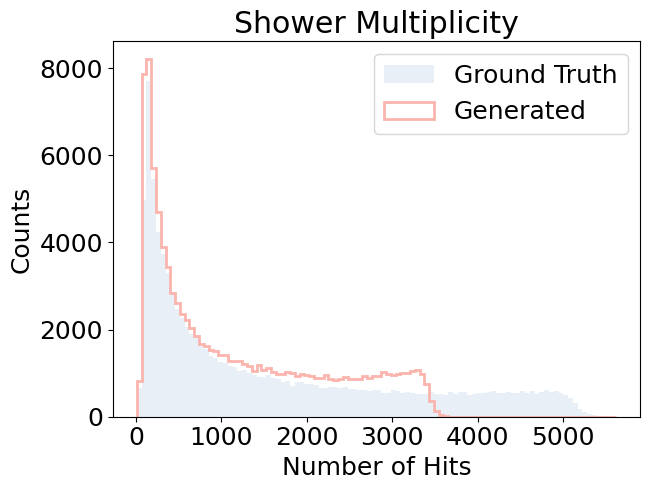

In [4]:
n_fake=(torch.cat(fake).reshape(-1,model.num_z*model.num_alpha*model.num_R)>0).sum(1)
n_real=(torch.cat(batches).reshape(-1,model.num_z*model.num_alpha*model.num_R)>0).sum(1)
_,b,_=plt.hist(n_real.cpu().numpy(),label="Ground Truth",bins=100,alpha=0.3,color="C1")
plt.hist(n_fake.cpu().numpy(),label="Generated",bins=b,alpha=1,color="C0",histtype="step",lw=2)


plt.legend()
plt.title("Shower Multiplicity")
plt.xlabel("Number of Hits")
plt.ylabel("Counts")
plt.tight_layout(pad=0.2)
plt.savefig("calo_n.pdf",format="pdf")



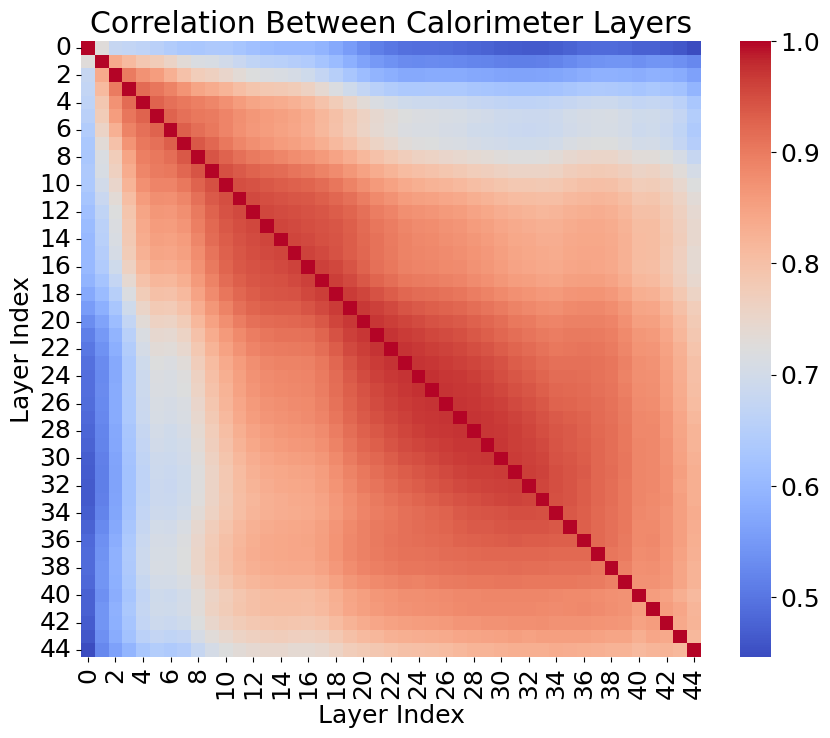

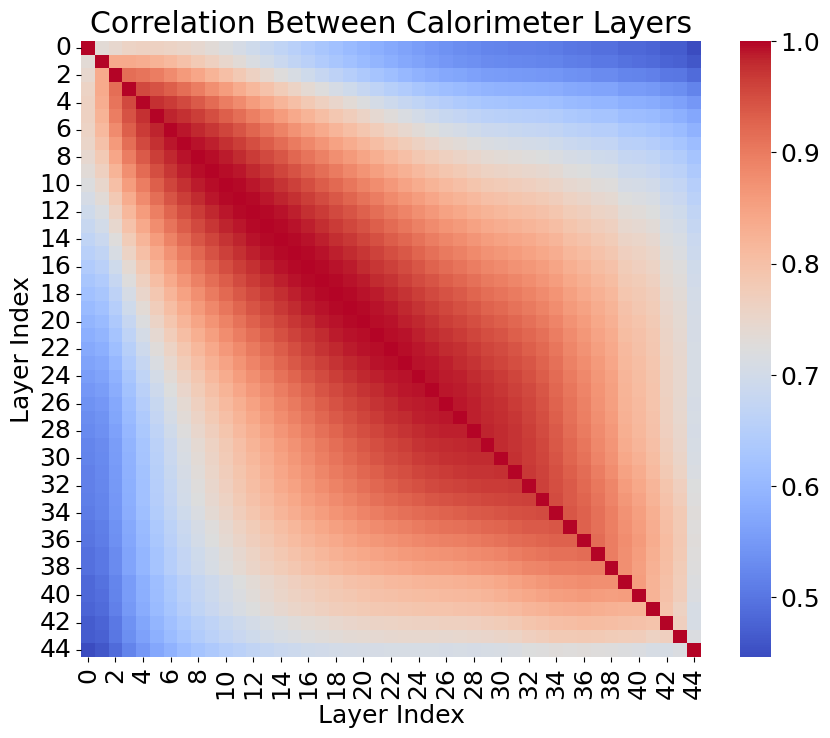

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate a 4D tensor for demonstration

def compute_correlation_matrix(tensor):
    # Sum over the angular and radial layers
    summed_tensor = tensor.sum(axis=(2, 3))
    
    # Compute the correlation matrix across the batch dimension
    correlation_matrix = np.corrcoef(summed_tensor, rowvar=False)
    
    return correlation_matrix

# Compute the correlation matrix
correlation_matrix = compute_correlation_matrix(torch.cat(fake).numpy())

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Between Calorimeter Layers")
plt.xlabel("Layer Index")
plt.ylabel("Layer Index")
plt.show()
correlation_matrix = compute_correlation_matrix(torch.cat(batches).numpy())

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Between Calorimeter Layers")
plt.xlabel("Layer Index")
plt.ylabel("Layer Index")
plt.show()

In [18]:
import h5py 
E=torch.cat(model.conds)[:,0,0].cpu()

with h5py.File("/beegfs/desy/user/kaechben/calochallenge/MDMA_dataset_2_new.hdf5".format("MDMA"), "w") as h5_file:
    
    N = len(fake) # find the length of my dataset
    h5_file.create_dataset('incident_energies', shape=(N, ), dtype=np.float64, data=(E+10).exp().double().cpu().numpy())
    h5_file.create_dataset('showers', shape=(N,fake.shape[3]*fake.shape[1]*fake.shape[2] ), dtype=np.float64, data=fake.double().reshape(-1,fake.shape[3]*fake.shape[1]*fake.shape[2]).numpy(), )#compression="gzip", compression_opts=9